In [1]:
import ROOT
import numpy as np
import pprint
from glob import glob
import os
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import re

import sys
sys.path.append('..')
from common import common
print(common.quantities)

Welcome to JupyROOT 6.18/04
['pT_yy', 'yAbs_yy', 'Dphi_j_j_30_signed', 'pT_j1_30', 'N_j_30', 'm_jj_30']


In [13]:
quantity = "pT_yy"
dataset = "AsimovSB"
method = 'binbybin'
workspace_folder = "../output/quickFit_binbybin/%s" % quantity

In [14]:
def loop_iterator(iterator):
  object = iterator.Next()
  while object:
    yield object
    object = iterator.Next()

def iter_collection(rooAbsCollection):
  iterator = rooAbsCollection.createIterator()
  return loop_iterator(iterator)

def create_dir_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [15]:
def extend_bin_labels(bin_labels, binning, add_underflow, add_overflow):
    """
    bin_labels: bin labels without under/overflow
    binning: binning without under/overflow
    """
    result = bin_labels[:]
    if add_overflow:
        result.append(r"$\geq %.1f$" % binning[-1])
    if add_underflow:
        result = [r"$< %.1f$" % binning[0]] + result
    return result

def get_binning_for_plot(binning):
    binning = np.copy(binning)
    if binning[-1] == np.inf:
        binning[-1] = (binning[-2] - binning[-3]) + binning[-2]
    if binning[0] == -np.inf:
        binning[0] = binning[1] - (binning[2] - binning[1])
    return binning

def remove_under_overflow(data, do_underflow, do_overflow):
    """
    given an array return a copy removing the first and/or the last element,
    depending on the flags
    """
    data = np.copy(data)
    if not do_overflow:
        data = data[:-1]
    if not do_underflow:
        data = data[1:]
    return data

In [16]:
latex_label = common.latex_labels[quantity]
binning = np.array(common.binnings[quantity])       # without under/over-flow
bin_labels = common.bin_labels[quantity]            # without under/over-flow
show_overflow = common.show_overflows[quantity]
show_underflow = common.show_underflows[quantity]

do_normalization = common.do_normalizations[quantity]
do_log_x = common.do_logs_x[quantity]
unit = common.unities_root_file[quantity]

if unit == 'MeV':
    binning /= 1000.

binning_with_extraflow = np.concatenate([[-np.inf], np.array(binning), [np.inf]])
bin_labels_extraflow = extend_bin_labels(bin_labels, binning, add_overflow=True, add_underflow=True)

# add -inf, +inf to the binning if needed
binning_with_extraflow = np.copy(np.array(binning))
if show_underflow:
    binning_with_extraflow = np.append(-np.inf, binning_with_extraflow)
if show_overflow:
    binning_with_extraflow = np.append(binning_with_extraflow, np.inf)

# create special bins for under/over-flow
binning_plot = get_binning_for_plot(binning_with_extraflow)

bin_labels_plot = remove_under_overflow(bin_labels_extraflow, do_underflow=show_underflow, do_overflow=show_overflow)

idx = list(range(len(common.binnings[quantity]) + 1))
idx_plot = remove_under_overflow(idx, do_underflow=show_underflow, do_overflow=show_overflow)
nbins_plot = len(idx_plot)

print("quantity: %s" % quantity)
print("label: %s" % latex_label)
print("binning: %s" % binning)
print('bin-labels (no under/over-flow): %s' % ', '.join(bin_labels))
print('show overflow: %s' % show_overflow)
print('show under: %s' % show_underflow)
print('do normalization: %s' % do_normalization)
print('do log-x: %s' % do_log_x)
print('unit: %s' % unit)
print("binning with extraflow %s" % binning_with_extraflow)
print("bin labes for plots %s" % bin_labels_plot)
print("binning plot %s" % binning_plot)

quantity: pT_yy
label: $p_{T}^{\gamma\gamma}$ [GeV]
binning: [  0.   5.  10.  15.  20.  25.  30.  35.  45.  60.  80. 100. 120. 140.
 170. 200. 250. 350.]
bin-labels (no under/over-flow): [0 - 5), [5 - 10), [10 - 15), [15 - 20), [20 - 25), [25 - 30), [30 - 35), [35 - 45), [45 - 60), [60 - 80), [80 - 100), [100 - 120), [120 - 140), [140 - 170), [170 - 200), [200 - 250), [250 - 350)
show overflow: True
show under: False
do normalization: True
do log-x: True
unit: MeV
binning with extraflow [  0.   5.  10.  15.  20.  25.  30.  35.  45.  60.  80. 100. 120. 140.
 170. 200. 250. 350.  inf]
bin labes for plots ['[0 - 5)' '[5 - 10)' '[10 - 15)' '[15 - 20)' '[20 - 25)' '[25 - 30)'
 '[30 - 35)' '[35 - 45)' '[45 - 60)' '[60 - 80)' '[80 - 100)'
 '[100 - 120)' '[120 - 140)' '[140 - 170)' '[170 - 200)' '[200 - 250)'
 '[250 - 350)' '$\\geq 350.0$']
binning plot [  0.   5.  10.  15.  20.  25.  30.  35.  45.  60.  80. 100. 120. 140.
 170. 200. 250. 350. 450.]


In [20]:
name_xsec_to_plot = np.array(['mu_xsec_{quantity}_{ibin}'.format(quantity=quantity, ibin=ibin) for ibin in idx_plot])
name_xsec_to_plot

array(['mu_xsec_pT_yy_1', 'mu_xsec_pT_yy_2', 'mu_xsec_pT_yy_3',
       'mu_xsec_pT_yy_4', 'mu_xsec_pT_yy_5', 'mu_xsec_pT_yy_6',
       'mu_xsec_pT_yy_7', 'mu_xsec_pT_yy_8', 'mu_xsec_pT_yy_9',
       'mu_xsec_pT_yy_10', 'mu_xsec_pT_yy_11', 'mu_xsec_pT_yy_12',
       'mu_xsec_pT_yy_13', 'mu_xsec_pT_yy_14', 'mu_xsec_pT_yy_15',
       'mu_xsec_pT_yy_16', 'mu_xsec_pT_yy_17', 'mu_xsec_pT_yy_18'],
      dtype='<U16')

In [17]:
fname_ws_fullfit = os.path.join(workspace_folder, 'XSectionWS_{quantity}-fitted_{dataset}.root'.format(quantity=quantity, dataset=dataset))
f_fullfit = ROOT.TFile.Open(fname_ws_fullfit)
fit_results_fullfit = f_fullfit.Get("fitResult")

In [18]:
def extract_info_from_fitresult(fit_results):
    fit_results_RooArgSet = fit_results.floatParsFinal()
    fit_results_collection = iter_collection(fit_results_RooArgSet)
    
    fit_results_list = []
    for fit_elem in fit_results_collection:
        fit_results_list.append([fit_elem.GetName(), fit_elem.getVal(), fit_elem.getError()])
    return fit_results_list
    
df_fullfit = extract_info_from_fitresult(fit_results_fullfit)
df_fullfit = pd.DataFrame(df_fullfit, columns=('name', 'value', 'error')).set_index('name')

In [21]:
all_dfs = {}

for fn in glob(os.path.join(workspace_folder, '*.root')):
    if dataset not in fn:
        continue
    if 'ATLAS' not in fn:
        continue
    m = re.search(r'(ATLAS_.+?)-fitted', fn)
    sysname = m.group(1).replace('_Uncertainty', '')
    
    f = ROOT.TFile.Open(fn)
    fit_result = f.Get("fitResult")
    
    df = extract_info_from_fitresult(fit_result)
    df = pd.DataFrame(df, columns=('name', 'value', 'error')).set_index('name')
    all_dfs[sysname] = df
    
df_allerr = pd.concat(all_dfs)
df_allerr = df_allerr.loc[pd.IndexSlice[:, name_xsec_to_plot], :]['error'].unstack()
df_allerr = df_allerr.reindex(name_xsec_to_plot, axis=1).fillna(0)
df_allerr

name                              mu_xsec_pT_yy_1  mu_xsec_pT_yy_2  \
ATLAS_lumi_run2_corr                     0.407053         0.310547   
ATLAS_Hgg_Bias_category_pT_yy_7          0.407210         0.310796   
ATLAS_Hgg_Bias_category_pT_yy_2          0.407601         0.272063   
ATLAS_Hgg_Bias_category_pT_yy_3          0.407185         0.310762   
ATLAS_Hgg_Bias_category_pT_yy_16         0.407601         0.311073   
ATLAS_Hgg_Bias_category_pT_yy_8          0.407575         0.311005   
ATLAS_PH_EFF_ISO                         0.407037         0.310471   
ATLAS_Hgg_Bias_category_pT_yy_18         0.407603         0.311005   
ATLAS_Hgg_Bias_category_pT_yy_4          0.407092         0.310645   
ATLAS_MSS_lhchcMass                      0.407116         0.310808   
ATLAS_Hgg_Bias_category_pT_yy_5          0.407571         0.310996   
ATLAS_Hgg_Bias_category_pT_yy_10         0.407586         0.311022   
ATLAS_Hgg_Bias_category_pT_yy_1          0.384433         0.310962   
ATLAS_Hgg_Trigger                        0.407599         0.311009   
ATLAS_PRW_DATASF                         0.407004         0.310414   
ATLAS_Hgg_Bias_category_pT_yy_15         0.407246         0.310751   
ATLAS_PH_EFF_ID                          0.406962         0.310332   
ATLAS_Hgg_Bias_category_pT_yy_13         0.407596         0.311027   
ATLAS_Hgg_Bias_category_pT_yy_6          0.407579         0.311045   
ATLAS_PH_EFF_TRIGGER                     0.407120         0.310681   
ATLAS_EG_SCALE_ALL                       0.407496         0.310850   
ATLAS_JET_Flavor_Composition             0.407603         0.311046   
ATLAS_Hgg_Bias_category_pT_yy_14         0.407222         0.310746   
ATLAS_Hgg_Bias_category_pT_yy_12         0.407609         0.311046   
ATLAS_EG_RESOLUTION_ALL                  0.408827         0.312676   
ATLAS_JET_JvtEfficiency                  0.407594         0.311042   
ATLAS_Hgg_Bias_category_pT_yy_17         0.407609         0.311055   
ATLAS_lumi_run2_uncorr                   0.407097         0.310565   
ATLAS_Hgg_Bias_category_pT_yy_9          0.407600         0.311023   
ATLAS_Hgg_Bias_category_pT_yy_11         0.407587         0.311027   

name                              mu_xsec_pT_yy_3  mu_xsec_pT_yy_4  \
ATLAS_lumi_run2_corr                     0.425573         0.309985   
ATLAS_Hgg_Bias_category_pT_yy_7          0.426293         0.310963   
ATLAS_Hgg_Bias_category_pT_yy_2          0.426399         0.310996   
ATLAS_Hgg_Bias_category_pT_yy_3          0.249486         0.310732   
ATLAS_Hgg_Bias_category_pT_yy_16         0.426471         0.310987   
ATLAS_Hgg_Bias_category_pT_yy_8          0.426657         0.310999   
ATLAS_PH_EFF_ISO                         0.425492         0.309774   
ATLAS_Hgg_Bias_category_pT_yy_18         0.426253         0.310959   
ATLAS_Hgg_Bias_category_pT_yy_4          0.426130         0.288431   
ATLAS_MSS_lhchcMass                      0.426383         0.311102   
ATLAS_Hgg_Bias_category_pT_yy_5          0.426373         0.310945   
ATLAS_Hgg_Bias_category_pT_yy_10         0.426291         0.311027   
ATLAS_Hgg_Bias_category_pT_yy_1          0.426398         0.311019   
ATLAS_Hgg_Trigger                        0.426404         0.310907   
ATLAS_PRW_DATASF                         0.425493         0.309732   
ATLAS_Hgg_Bias_category_pT_yy_15         0.426276         0.310972   
ATLAS_PH_EFF_ID                          0.425280         0.309356   
ATLAS_Hgg_Bias_category_pT_yy_13         0.426481         0.310953   
ATLAS_Hgg_Bias_category_pT_yy_6          0.426390         0.310965   
ATLAS_PH_EFF_TRIGGER                     0.426026         0.310533   
ATLAS_EG_SCALE_ALL                       0.426390         0.310459   
ATLAS_JET_Flavor_Composition             0.426553         0.310997   
ATLAS_Hgg_Bias_category_pT_yy_14         0.426194         0.311004   
ATLAS_Hgg_Bias_category_pT_yy_12         0.426601         0.311001   
ATLAS_EG_RESOLUTION_ALL                  0.424984         0.306699   
ATLAS_JET

In [22]:
df_allerr_nominal = df_fullfit['error'].reindex(name_xsec_to_plot).fillna(0)
df_allerr_nominal.to_frame('Nominal').T

name     mu_xsec_pT_yy_1  mu_xsec_pT_yy_2  mu_xsec_pT_yy_3  mu_xsec_pT_yy_4  \
Nominal         0.411502         0.317684         0.423565         0.302519   

name     mu_xsec_pT_yy_5  mu_xsec_pT_yy_6  mu_xsec_pT_yy_7  mu_xsec_pT_yy_8  \
Nominal         0.378688         0.321918         0.385592         0.285594   

name     mu_xsec_pT_yy_9  mu_xsec_pT_yy_10  mu_xsec_pT_yy_11  \
Nominal         0.282646          0.246501          0.350185   

name     mu_xsec_pT_yy_12  mu_xsec_pT_yy_13  mu_xsec_pT_yy_14  \
Nominal          0.386469          0.336555          0.308718   

name     mu_xsec_pT_yy_15  mu_xsec_pT_yy_16  mu_xsec_pT_yy_17  \
Nominal          0.338273          0.281439          0.294725   

name     mu_xsec_pT_yy_18  
Nominal          0.463864

In [23]:
df_sys = np.sqrt(df_allerr_nominal ** 2 - df_allerr ** 2).fillna(0)
df_sys

/home/turra/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


name                              mu_xsec_pT_yy_1  mu_xsec_pT_yy_2  \
ATLAS_lumi_run2_corr                     0.060349         0.066962   
ATLAS_Hgg_Bias_category_pT_yy_7          0.059282         0.065798   
ATLAS_Hgg_Bias_category_pT_yy_2          0.056527         0.164028   
ATLAS_Hgg_Bias_category_pT_yy_3          0.059448         0.065957   
ATLAS_Hgg_Bias_category_pT_yy_16         0.056527         0.064475   
ATLAS_Hgg_Bias_category_pT_yy_8          0.056712         0.064801   
ATLAS_PH_EFF_ISO                         0.060454         0.067313   
ATLAS_Hgg_Bias_category_pT_yy_18         0.056513         0.064803   
ATLAS_Hgg_Bias_category_pT_yy_4          0.060083         0.066507   
ATLAS_MSS_lhchcMass                      0.059920         0.065742   
ATLAS_Hgg_Bias_category_pT_yy_5          0.056746         0.064844   
ATLAS_Hgg_Bias_category_pT_yy_10         0.056633         0.064723   
ATLAS_Hgg_Bias_category_pT_yy_1          0.146783         0.065009   
ATLAS_Hgg_Trigger                        0.056541         0.064782   
ATLAS_PRW_DATASF                         0.060678         0.067576   
ATLAS_Hgg_Bias_category_pT_yy_15         0.059031         0.066008   
ATLAS_PH_EFF_ID                          0.060959         0.067952   
ATLAS_Hgg_Bias_category_pT_yy_13         0.056563         0.064698   
ATLAS_Hgg_Bias_category_pT_yy_6          0.056687         0.064610   
ATLAS_PH_EFF_TRIGGER                     0.059891         0.066339   
ATLAS_EG_SCALE_ALL                       0.057277         0.065542   
ATLAS_JET_Flavor_Composition             0.056514         0.064605   
ATLAS_Hgg_Bias_category_pT_yy_14         0.059195         0.066031   
ATLAS_Hgg_Bias_category_pT_yy_12         0.056472         0.064603   
ATLAS_EG_RESOLUTION_ALL                  0.046843         0.056189   
ATLAS_JET_JvtEfficiency                  0.056581         0.064626   
ATLAS_Hgg_Bias_category_pT_yy_17         0.056470         0.064564   
ATLAS_lumi_run2_uncorr                   0.060050         0.066881   
ATLAS_Hgg_Bias_category_pT_yy_9          0.056537         0.064715   
ATLAS_Hgg_Bias_category_pT_yy_11         0.056632         0.064698   

name                              mu_xsec_pT_yy_3  mu_xsec_pT_yy_4  \
ATLAS_lumi_run2_corr                     0.000000         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_7          0.000000         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_2          0.000000         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_3          0.342291         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_16         0.000000         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_8          0.000000         0.000000   
ATLAS_PH_EFF_ISO                         0.000000         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_18         0.000000         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_4          0.000000         0.091243   
ATLAS_MSS_lhchcMass                      0.000000         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_5          0.000000         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_10         0.000000         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_1          0.000000         0.000000   
ATLAS_Hgg_Trigger                        0.000000         0.000000   
ATLAS_PRW_DATASF                         0.000000         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_15         0.000000         0.000000   
ATLAS_PH_EFF_ID                          0.000000         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_13         0.000000         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_6          0.000000         0.000000   
ATLAS_PH_EFF_TRIGGER                     0.000000         0.000000   
ATLAS_EG_SCALE_ALL                       0.000000         0.000000   
ATLAS_JET_Flavor_Composition             0.000000         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_14         0.000000         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_12         0.000000         0.000000   
ATLAS_EG_RESOLUTION_ALL                  0.000000         0.000000   
ATLAS_JET

In [24]:
leading_sys = df_sys.abs().median(axis=1).sort_values(ascending=False).index[:6]
notleading_sys = [sysname for sysname in df_sys.index if sysname not in leading_sys]

In [25]:
df_sys_leading = df_sys.reindex(leading_sys)
df_sys_leading.loc['others'] = np.sqrt((df_sys.reindex(notleading_sys) ** 2).sum(axis=0))
df_sys_leading

name                              mu_xsec_pT_yy_1  mu_xsec_pT_yy_2  \
ATLAS_EG_SCALE_ALL                       0.057277         0.065542   
ATLAS_Hgg_Bias_category_pT_yy_4          0.060083         0.066507   
ATLAS_Hgg_Bias_category_pT_yy_7          0.059282         0.065798   
ATLAS_Hgg_Bias_category_pT_yy_3          0.059448         0.065957   
ATLAS_Hgg_Bias_category_pT_yy_14         0.059195         0.066031   
ATLAS_Hgg_Bias_category_pT_yy_15         0.059031         0.066008   
others                                   0.311821         0.352499   

name                              mu_xsec_pT_yy_3  mu_xsec_pT_yy_4  \
ATLAS_EG_SCALE_ALL                       0.000000         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_4          0.000000         0.091243   
ATLAS_Hgg_Bias_category_pT_yy_7          0.000000         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_3          0.342291         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_14         0.000000         0.000000   
ATLAS_Hgg_Bias_category_pT_yy_15         0.000000         0.000000   
others                                   0.000000         0.000000   

name                              mu_xsec_pT_yy_5  mu_xsec_pT_yy_6  \
ATLAS_EG_SCALE_ALL                       0.018946         0.067050   
ATLAS_Hgg_Bias_category_pT_yy_4          0.019687         0.066731   
ATLAS_Hgg_Bias_category_pT_yy_7          0.020243         0.066408   
ATLAS_Hgg_Bias_category_pT_yy_3          0.018621         0.066488   
ATLAS_Hgg_Bias_category_pT_yy_14         0.019025         0.066106   
ATLAS_Hgg_Bias_category_pT_yy_15         0.018168         0.066028   
others                                   0.246405         0.325262   

name                              mu_xsec_pT_yy_7  mu_xsec_pT_yy_8  \
ATLAS_EG_SCALE_ALL                       0.000000         0.043283   
ATLAS_Hgg_Bias_category_pT_yy_4          0.000000         0.041855   
ATLAS_Hgg_Bias_category_pT_yy_7          0.175708         0.041596   
ATLAS_Hgg_Bias_category_pT_yy_3          0.000000         0.041648   
ATLAS_Hgg_Bias_category_pT_yy_14         0.000000         0.040949   
ATLAS_Hgg_Bias_category_pT_yy_15         0.000000         0.040789   
others                                   0.000000         0.223327   

name                              mu_xsec_pT_yy_9  mu_xsec_pT_yy_10  \
ATLAS_EG_SCALE_ALL                       0.054564          0.046316   
ATLAS_Hgg_Bias_category_pT_yy_4          0.054096          0.045648   
ATLAS_Hgg_Bias_category_pT_yy_7          0.053688          0.045244   
ATLAS_Hgg_Bias_category_pT_yy_3          0.053872          0.045548   
ATLAS_Hgg_Bias_category_pT_yy_14         0.053834          0.045189   
ATLAS_Hgg_Bias_category_pT_yy_15         0.053687          0.045100   
others                                   0.290164          0.226308   

name                              mu_xsec_pT_yy_11  mu_xsec_pT_yy_12  \
ATLAS_EG_SCALE_ALL                        0.044658          0.000000   
ATLAS_Hgg_Bias_category_pT_yy_4           0.042219          0.000000   
ATLAS_Hgg_Bias_category_pT_yy_7           0.041475          0.000000   
ATLAS_Hgg_Bias_category_pT_yy_3           0.042316          0.000000   
ATLAS_Hgg_Bias_category_pT_yy_14          0.041351          0.000000   
ATLAS_Hgg_Bias_category_pT_yy_15          0.041048          0.000000   
others                                    0.268750          0.225074   

name                              mu_xsec_pT_yy_13  mu_xsec_pT_yy_14  \
ATLAS_EG_SCALE_ALL                        0.039450          0.000000   
ATLAS_Hgg_Bias_category_pT_yy_4           0.031582          0.000000   
ATLAS_Hgg_Bias_category_pT_yy_7           0.030466          0.000000   
ATLAS_Hgg_Bias_category_pT_yy_3           0.030430          0.000000   
ATLAS_Hgg_Bias_category_pT_yy_14          0.030185          0.148493   
ATLAS_Hgg_Bias_category_pT_yy_15          0.029702          0.000000   
others                                    0.164855          0.000000   

name                             

[]

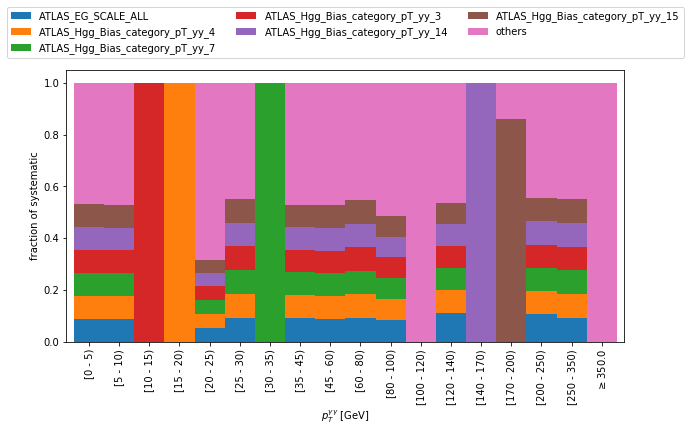

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
((df_sys_leading) / df_sys_leading.sum(axis=0)).T.plot.bar(stacked=True, width=1, ax=ax)
ax.set_xticklabels(bin_labels_plot)
ax.set_xlabel('%s' % latex_label)
ax.set_ylabel('fraction of systematic')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=3)
plt.plot()